# Import dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.data.build_graph import build_graphs
from utils.data.load_graphs import load_graphs
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train_3 import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=True)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 155 ms, sys: 105 ms, total: 260 ms
Wall time: 259 ms


Choose number of events to be analysed

In [3]:
run = 'seg_1'
run_title = 'graph segment 1 of 3'

nevents = raw.index.max()
nevents = 50
node_dim = 2
edge_dim = 2

# Investigate raw data

In [4]:
%%time

show=False
if show:
   
    plot_information(raw, name=run, nevents=30000).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    evID = 3
    event = raw.loc[raw.index==evID]
    plot_event(event, scale=1.8, name=run).plot_eventdisplay()
    
    data_eval = evaluate_data(raw, ncuts=50, nevents=30000, name=run)
    data_eval.curler_dist()

    purity, efficiency, cuts, cutPos, TNR, FNR = data_eval.find_pzcut()
    data = plot_information(name=run, nevents=nevents)
    data.plot_purity_efficiency(
        cuts, 
        25, 
        purity, 
        efficiency, 
        TNR, 
        FNR, 
        nevents, 
        variable = r'$p_z^{min}$', 
        unit= 'GeV/c',
        xname = r'$p_z^{min}$ (GeV/c)', 
        yname = 'purity & efficiency', 
        save_name = f'img/3_pz_threshold_{run}.pdf')

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 4.77 µs


# Graph building for training

In [5]:
in_dir = 'data/graphs'

pz_min = 0.001
slope_max = 2.
minlayer=0
maxlayer=8

graph_dir = f'{in_dir}_{run}_pzmin_{pz_min}_slopemax_{slope_max}'

In [6]:
%%time

data = build_graphs(raw,end=30000, shuffle=True,  pz_min=pz_min, remove_duplicates=True, slope=slope_max, graph_dir=graph_dir)
create_g = False

if create_g:
    graphs = data.create_graph_list(node_dim=node_dim, edge_dim=edge_dim, minlayer=minlayer, maxlayer=maxlayer)
    print(f'graphs saved to {graph_dir}')

    Nedges, Ntrue, Nnodes = 0,0,0     
    for g in graphs:
        Nedges += len(g.y)
        Ntrue += sum(g.y)
        Nnodes += len(g.x)
    print(f'Nedges: {Nedges}, Ntrue: {Ntrue}, Ntrue/Nedges: {Ntrue/Nedges}, meanNedges: {Nedges/nevents}')
    print(f'Nnodes: {Nnodes}, Nedges/Nnodes: {Nedges/Nnodes}')
    
else:
    graphs = load_graphs(graph_dir, n_graphs=nevents, node_dim=node_dim, edge_dim=edge_dim) #load n random sample graphs

#show preprocessed data
data.events.sort_index()

Nedges: 3165, Ntrue: 1574, Ntrue/Nedges: 0.4973143759873618
Nnodes: 1844, Nedges/Nnodes: 1.7163774403470715
CPU times: user 2.14 s, sys: 425 ms, total: 2.57 s
Wall time: 2.55 s


,hit_id,particle_id,x,z,iso,pz,chamber_id,skewed,layer_id,layer,Hit_id
event_id,,,,,,,,,,,
0,547,2,29.542500,309.390015,0.380595,7.657896,1,0,7,3,106
0,20378,2,71.457497,654.364685,0.103020,7.614486,6,0,48,24,148
0,727353,0,27.522499,437.489990,0.119575,2.421842,4,0,25,13,221
0,1283618,3,-32.067501,653.489990,0.158261,7.700203,6,0,47,23,99
0,1944183,0,18.937500,327.769684,0.309845,2.432236,2,0,10,6,206
...,...,...,...,...,...,...,...,...,...,...,...
29999,933381,3,5.807500,423.839691,0.037754,5.498756,3,0,24,12,120
29999,623789,0,5.302500,653.489990,0.086463,7.105002,6,0,47,23,239
29999,1988600,5,7.827500,342.264679,0.104802,1.379045,2,0,16,8,15


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

In [7]:
test_samples = 1000
show_graph_dims = False

if show_graph_dims:
    show_infos = plot_information(graphs=graphs[:test_samples], pz_min=pz_min, slope_max=slope_max, name=run)
    show_infos.plot_graph_data_info(bins=30, log=True)

In [8]:
%%time
evaluate_gb = False
test_samples = 1000
ncuts = 100

if evaluate_gb:
        
    testdata = build_graphs(raw,end=test_samples, shuffle=True, pz_min=pz_min, remove_duplicates=True, slope=slope_max)
    slope = np.linspace(0.1,2,ncuts)
    purities, efficiencies, TNRs, FNRs = np.zeros((4,ncuts))
    nnodes, nedges = [], []
           
    for i, s in enumerate(tqdm(slope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False, node_dim=2, edge_dim=2, minlayer=minlayer, maxlayer=maxlayer)
        purity, efficiency, TNR, FNR, _ = evaluate_graphs(testdata.events, testgraphs, name=run).evaluate_graphs(show_progress=False)
        purities[i] = purity
        efficiencies[i] = efficiency
        TNRs[i] = TNR
        FNRs[i] = FNR
        
        ne = []
        
        for g in testgraphs:
            ne.append(len(g.y))
        nedges.append([np.mean(ne), np.std(ne)])
    nn = []
    for g in testgraphs:
        nn.append(len(g.x))
    nnodes = [np.mean(nn), np.std(nn)]
    print(f'average number of nodes: {nnodes[0]:.2f} with standard deviation {nnodes[1]:.2f}')
    nedges = np.array(nedges)
        
                
    show_infos = plot_information(graphs=graphs[:test_samples], pz_min=pz_min, slope_max=slope_max, name=run)
    cutPos = np.argmin(np.abs(np.array(purities)-np.array(efficiencies)))
    cutPos = 47

    show_infos.plot_purity_efficiency(
        cuts=slope, 
        cut_pos=cutPos, 
        purity=purities, 
        efficiency=efficiencies, 
        TNR=TNRs, 
        FNR=FNRs, 
        nevents=test_samples, 
        variable=r'$s^{max}$',
        xname=r'$s^{max}$', 
        yname='purity & efficiency', 
        save_name=f'img/3_graphbuilding_purity_efficiency_{run}.pdf', 
        add_inf=r',  $p_z^{min} =$ '+f'{pz_min:.3f} GeV/c',
        legloc='center right', 
        scale=1.38)
        
    
    show_infos.plot_graph_dimensions(nnodes, nedges, slope, test_samples)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


# Plot Graphs

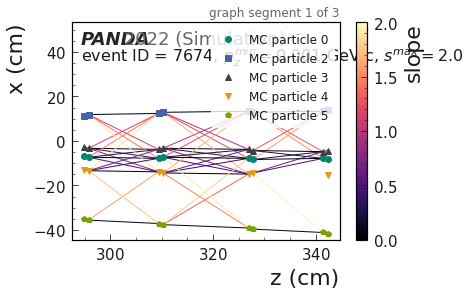

CPU times: user 968 ms, sys: 1.17 s, total: 2.14 s
Wall time: 761 ms


In [9]:
%%time
# evID = np.random.randint(nevents)
evID = 3
plot_graphs=True
    
if plot_graphs:    

    hits = data.events.loc[evID]
    graph = graphs[evID]
    
    plotevent = plot_event(hits, graph=graph, shift=.14, scale=1.6, name=run, title=run_title)
    # plotevent.plot_eventdisplay()
    plotevent.plot_graphdisplay(pz_min=pz_min, slope_max=slope_max, show_slope=True, colormap='magma', reverse_cm=False)


# Prepare Training

In [10]:
# torch.manual_seed(42)
device = 'cpu'
hidden_size = 8
lr = 0.01
gamma = 0.7
epochs = 20
patience = 5
step_size = 4


name = f'IN_nevents_{nevents}_hidden_{hidden_size}_lr_{lr}_gamma_{gamma}_steps_{step_size}'


In [11]:
batch_size = 1
parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples
load_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 16}

parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}


train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **load_params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **load_params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **load_params)

In [12]:
model = InteractionNetwork(node_dim, edge_dim, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

model.count_parameters()

InteractionNetwork(node_dim: 2, edge_dim: 2, hidden_size: 8)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     48     |
|  R1.layers.0.bias  |     8      |
| R1.layers.2.weight |     64     |
|  R1.layers.2.bias  |     8      |
| R1.layers.4.weight |     16     |
|  R1.layers.4.bias  |     2      |
| O.layers.0.weight  |     32     |
|  O.layers.0.bias   |     8      |
| O.layers.2.weight  |     64     |
|  O.layers.2.bias   |     8      |
| O.layers.4.weight  |     16     |
|  O.layers.4.bias   |     2      |
| R2.layers.0.weight |     48     |
|  R2.layers.0.bias  |     8      |
| R2.layers.2.weight |     64     |
|  R2.layers.2.bias  |     8      |
| R2.layers.4.weight |     8      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 413


# Training

In [13]:
results = train_model(
    train_loader, 
    val_loader, 
    model, 
    optimizer, 
    scheduler, 
    device=device,
    epochs=epochs, 
    patience=patience, 
    run=run,
    name=name
)


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 0.62s
Mean Train Batch Loss: 0.6888


  5%|█████                                                                                               | 1/20 [00:00<00:18,  1.05it/s]


 Validation set: Average loss: 0.7038
, Accuracy: 0.4620

Validation loss decreased (inf --> 0.703768).  Saving model ...
Train Epoch: 2, epoch time: 0.53s
Mean Train Batch Loss: 0.6857


 10%|██████████                                                                                          | 2/20 [00:01<00:16,  1.11it/s]


 Validation set: Average loss: 0.7023
, Accuracy: 0.4620

Validation loss decreased (0.703768 --> 0.702308).  Saving model ...
Train Epoch: 3, epoch time: 0.56s
Mean Train Batch Loss: 0.6741


 15%|███████████████                                                                                     | 3/20 [00:02<00:15,  1.13it/s]


 Validation set: Average loss: 0.6783
, Accuracy: 0.5543

Validation loss decreased (0.702308 --> 0.678281).  Saving model ...
Train Epoch: 4, epoch time: 0.48s
Mean Train Batch Loss: 0.6527


 20%|████████████████████                                                                                | 4/20 [00:03<00:13,  1.16it/s]


 Validation set: Average loss: 0.6691
, Accuracy: 0.6114

Validation loss decreased (0.678281 --> 0.669103).  Saving model ...
Train Epoch: 5, epoch time: 0.54s
Mean Train Batch Loss: 0.5701


 25%|█████████████████████████                                                                           | 5/20 [00:04<00:12,  1.16it/s]


 Validation set: Average loss: 0.5705
, Accuracy: 0.6929

Validation loss decreased (0.669103 --> 0.570504).  Saving model ...
Train Epoch: 6, epoch time: 0.47s
Mean Train Batch Loss: 0.4493


 30%|██████████████████████████████                                                                      | 6/20 [00:05<00:11,  1.20it/s]


 Validation set: Average loss: 0.4432
, Accuracy: 0.8234

Validation loss decreased (0.570504 --> 0.443248).  Saving model ...
Train Epoch: 7, epoch time: 0.53s
Mean Train Batch Loss: 0.3404


 35%|███████████████████████████████████                                                                 | 7/20 [00:05<00:10,  1.20it/s]


 Validation set: Average loss: 0.3681
, Accuracy: 0.8560

Validation loss decreased (0.443248 --> 0.368069).  Saving model ...
Train Epoch: 8, epoch time: 0.50s
Mean Train Batch Loss: 0.3079


 40%|████████████████████████████████████████                                                            | 8/20 [00:06<00:09,  1.22it/s]


 Validation set: Average loss: 0.3718
, Accuracy: 0.8505

EarlyStopping counter: 1 out of 5
Train Epoch: 9, epoch time: 0.54s
Mean Train Batch Loss: 0.2926


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:07<00:09,  1.20it/s]


 Validation set: Average loss: 0.4137
, Accuracy: 0.8179

EarlyStopping counter: 2 out of 5
Train Epoch: 10, epoch time: 0.55s
Mean Train Batch Loss: 0.2732


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:08<00:08,  1.18it/s]


 Validation set: Average loss: 0.3281
, Accuracy: 0.8641

Validation loss decreased (0.368069 --> 0.328105).  Saving model ...
Train Epoch: 11, epoch time: 0.58s
Mean Train Batch Loss: 0.2659


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:09<00:07,  1.16it/s]


 Validation set: Average loss: 0.3536
, Accuracy: 0.8533

EarlyStopping counter: 1 out of 5
Train Epoch: 12, epoch time: 0.57s
Mean Train Batch Loss: 0.2641


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:10<00:06,  1.15it/s]


 Validation set: Average loss: 0.3715
, Accuracy: 0.8451

EarlyStopping counter: 2 out of 5
Train Epoch: 13, epoch time: 0.52s
Mean Train Batch Loss: 0.2597


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:11<00:05,  1.18it/s]


 Validation set: Average loss: 0.3892
, Accuracy: 0.8478

EarlyStopping counter: 3 out of 5
Train Epoch: 14, epoch time: 0.52s
Mean Train Batch Loss: 0.2512


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:11<00:05,  1.19it/s]


 Validation set: Average loss: 0.3434
, Accuracy: 0.8641

EarlyStopping counter: 4 out of 5
Train Epoch: 15, epoch time: 0.55s
Mean Train Batch Loss: 0.2465


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:12<00:05,  1.10it/s]


 Validation set: Average loss: 0.3417
, Accuracy: 0.8668

EarlyStopping counter: 5 out of 5
Early stopping


# Evaluate Training

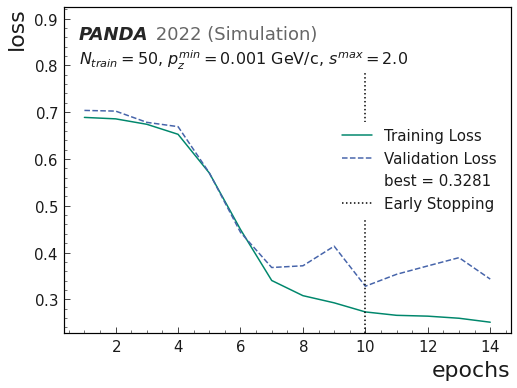

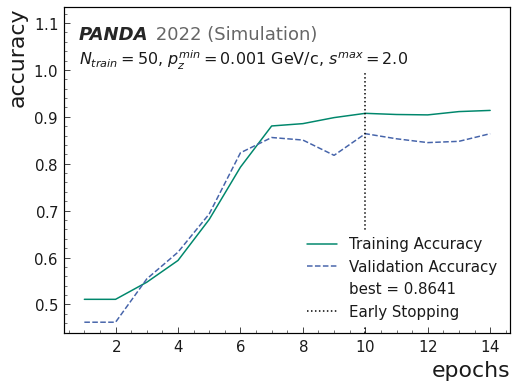

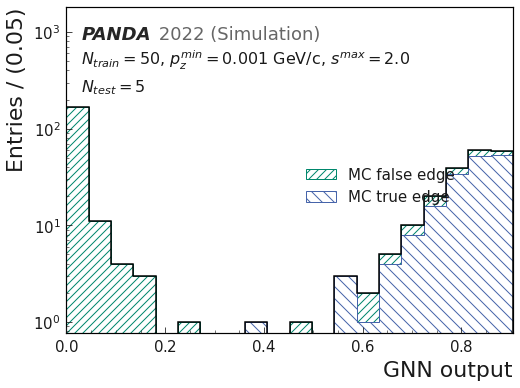

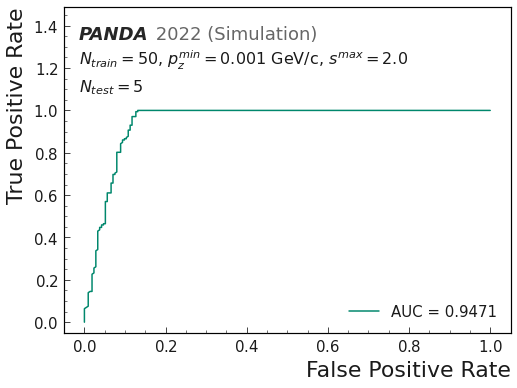

 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 91/100 [00:00<00:00, 124124.12it/s]


ZeroDivisionError: division by zero

In [14]:
model, train_output = results.trained

threshold = 0.7
evaluation = evaluate_model(model, 
                            test_loader, 
                            pz_min, 
                            slope_max, 
                            nevents,
                            train_output, 
                            threshold, 
                            ncuts=100, 
                            name=run)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics(output_bins=20, scale=1.5)

# Show Results

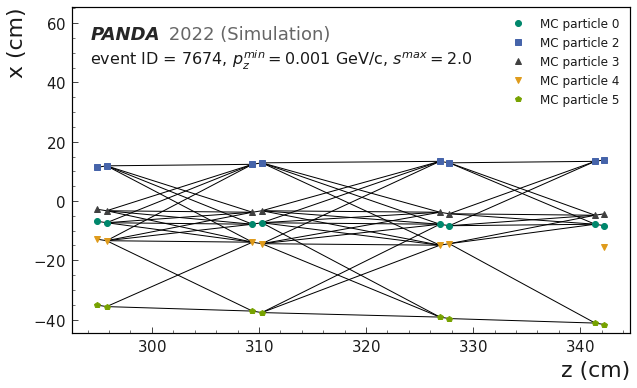

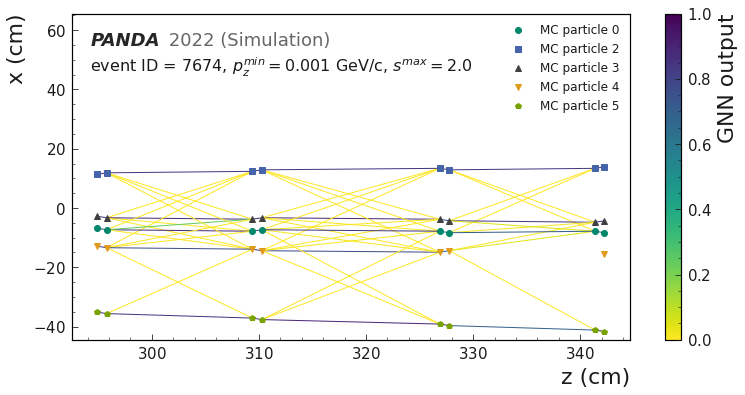

In [15]:
plot_event(hits, graph, scale=1.8, name=run+'_black').plot_graphdisplay(pz_min=pz_min, slope_max=slope_max, show_slope=False)
plot_event(hits, graph, name=run, scale=1.8).plot_traineddisplay(model, pz_min=pz_min, slope_max=slope_max)


In [17]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

outputs, targets, zs = [], [], []

for d in tqdm(test_loader):
    output = model(d).squeeze(1).detach().numpy()
    y = d.y.detach().numpy()
    
    outputs = np.append(outputs, output)
    targets = np.append(targets, y) 
    zs = np.append(zs, np.abs(d.edge_attr[:,1].detach().numpy())*100)
    
thld = 0.8
outputs[outputs > thld] = 1.
outputs[outputs < thld] = 0.

equal = np.equal(outputs, targets)
arr = np.stack((equal,zs), axis=1)
bins = np.unique(arr[:,1])
inds = np.digitize(arr[:,1], bins)

test = np.zeros((len(bins),3))

for i, b in enumerate(bins):
    arr_binned = arr[inds==i+1][:,0]
    test[i] = [b, np.mean(arr_binned), np.std(arr_binned)]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.02it/s]


Text(0, 1, 'accuracy')

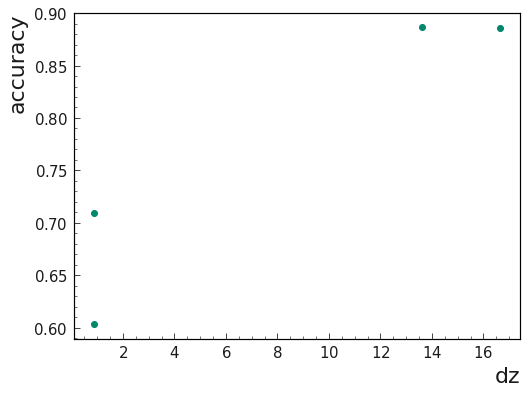

In [19]:
plt.plot(test[:,0], test[:,1], 'o')
plt.xlabel('dz')
plt.ylabel('accuracy')